In [1]:
#%pip install xesmf

In [2]:
import os



import matplotlib.pyplot as plt
import matplotlib, sys
#matplotlib.use('Agg')

import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
#import netCDF4 as nc4
import time
import dask.array as da
import sys
import s3fs


import cartopy.crs as ccrs
import pyproj
import time
import gc
from glob import glob

import xesmf as xe

In [7]:
nesosim_ds['date'] = xr.DataArray(pd.to_datetime(nesosim_ds['day'].values, format='%Y%m%d'), dims=['day'], coords={'day': nesosim_ds.day})

In [30]:
nesosim_ds = xr.open_mfdataset('~/Data/NESOSIMv11/*_010920*.nc')
#nesosim_ds['date'] = pd.to_datetime(nesosim_ds['day'], format='%Y%m%d')
nesosim_ds['date'] = xr.DataArray(pd.to_datetime(nesosim_ds['day'].values, format='%Y%m%d'), dims=['day'], coords={'day': nesosim_ds.day})
#nesosim_ds = nesosim_ds.assign_coords(time = nesosim_ds.time, x=nesosim_ds.x, y=nesosim_ds.y)
nesosim_ds = nesosim_ds.swap_dims({'day': 'date'})
nesosim_ds['longitude'] = nesosim_ds.longitude.isel(date=0)
nesosim_ds['latitude'] = nesosim_ds.latitude.isel(date=0)
nesosim_ds = nesosim_ds.set_coords(['longitude', 'latitude'])
nesosim_ds.drop_vars(['forcings', 'projection', 'parameters'])
nesosim_ds

<xarray.Dataset> Size: 2GB
Dimensions:            (date: 5571, y: 90, x: 90)
Coordinates:
    day                (date) int32 22kB 20000901 20000902 ... 20230429 20230430
    longitude          (y, x) float32 32kB dask.array<chunksize=(90, 90), meta=np.ndarray>
    latitude           (y, x) float32 32kB dask.array<chunksize=(90, 90), meta=np.ndarray>
  * date               (date) datetime64[ns] 45kB 2000-09-01 ... 2023-04-30
Dimensions without coordinates: y, x
Data variables:
    projection         (date) float64 45kB -2.147e+09 -2.147e+09 ... -2.147e+09
    forcings           (date) float64 45kB -2.147e+09 -2.147e+09 ... nan nan
    parameters         (date) float64 45kB -2.147e+09 -2.147e+09 ... nan nan
    xgrid              (date, y, x) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
    ygrid              (date, y, x) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
    snow_depth         (date, y, x) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
    snow_volume        (date, y, x) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
    snow_density       (date, y, x) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
    snowfall           (date, y, x) float32 181MB dask.array<chunksize=(242, 90, 90), meta=np.ndarray>
    ice_concentration  (date, y, x) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
    wind_speed         (date, y, x) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
    precipitation      (date, x, y) float32 181MB dask.array<chunksize=(5329, 90, 90), meta=np.ndarray>
Attributes:
    reference:    github.com/akpetty/NESOSIM
    contact:      alek.a.petty@nasa.gov
    description:  Daily snow on sea ice (depth and density) from the NASA Eul...
    history:      Created 24/04/21
    data_range:   Date range: 20000901-20010430

In [35]:
nesosim_ds = nesosim_ds.sel(date=nesosim_ds.date > np.datetime64('2018-08-15'))

#nesosim_ds.isel('date'>'2018')

In [36]:
# Destination grid
ease_grid = xr.open_dataset('./NSIDC0772_LatLon_EASE2_N25km_v1.0.nc')
ease_grid

<xarray.Dataset> Size: 8MB
Dimensions:    (x: 720, y: 720)
Coordinates:
  * x          (x) float64 6kB -8.988e+06 -8.962e+06 ... 8.962e+06 8.988e+06
  * y          (y) float64 6kB 8.988e+06 8.962e+06 ... -8.962e+06 -8.988e+06
Data variables:
    crs        int32 4B ...
    latitude   (y, x) float64 4MB ...
    longitude  (y, x) float64 4MB ...
Attributes: (12/38)
    title:                     EASE2 Grid Ancillary Grid Information
    summary:                   This data set provides the latitude and longit...
    id:                        10.5067/GE8ET0MZ5ZVF
    metadata_link:             https://doi.org/10.5067/GE8ET0MZ5ZVF
    license:                   Access Constraint: These data are freely, open...
    acknowledgment:            These data are produced and supported by the N...
    ...                        ...
    geospatial_lat_max:        90.0
    geospatial_lon_min:        -180.0
    geospatial_lon_max:        180.0
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east
    product_version:           1.0

In [38]:
# Initialize the regridder
# https://xesmf.readthedocs.io/en/stable/notebooks/Compare_algorithms.html
regridder = xe.Regridder(nesosim_ds.isel(date=0), ease_grid, 'nearest_s2d')

In [39]:
nesosim_ds_regridded = regridder(nesosim_ds)

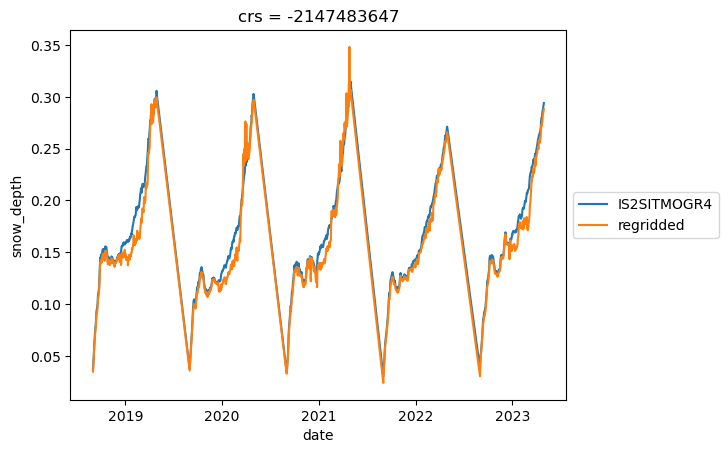

In [40]:
plt.figure()
nesosim_ds.snow_depth.mean(axis=[1, 2]).plot(label='IS2SITMOGR4')
nesosim_ds_regridded.snow_depth.mean(axis=[1, 2]).plot(label='regridded', add_legend=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
#method_list = [
#    "bilinear",
#    "nearest_s2d",
#    "nearest_d2s",
#    "patch",
#]
#fig, axes = plt.subplots(2, 2, figsize=[8, 8])
#
#for i, method in enumerate(method_list):
#    print(method)
#    ax = axes.flatten()[i]
#    regridder = xe.Regridder(is2_ds.isel(time=0), ease_grid, method)
#    is2_ds_regridded = regridder(is2_ds)
#    is2_ds.freeboard_int.mean(axis=[1, 2]).plot(ax=ax, label='IS2SITMOGR4')
#    is2_ds_regridded.freeboard_int.mean(axis=[1, 2]).plot(ax=ax, label='regridded', add_legend=True)
#    ax.set_title(method, fontsize=15)

#plt.tight_layout()

2018-12-10
2019-01-09
2019-02-08
2019-03-10


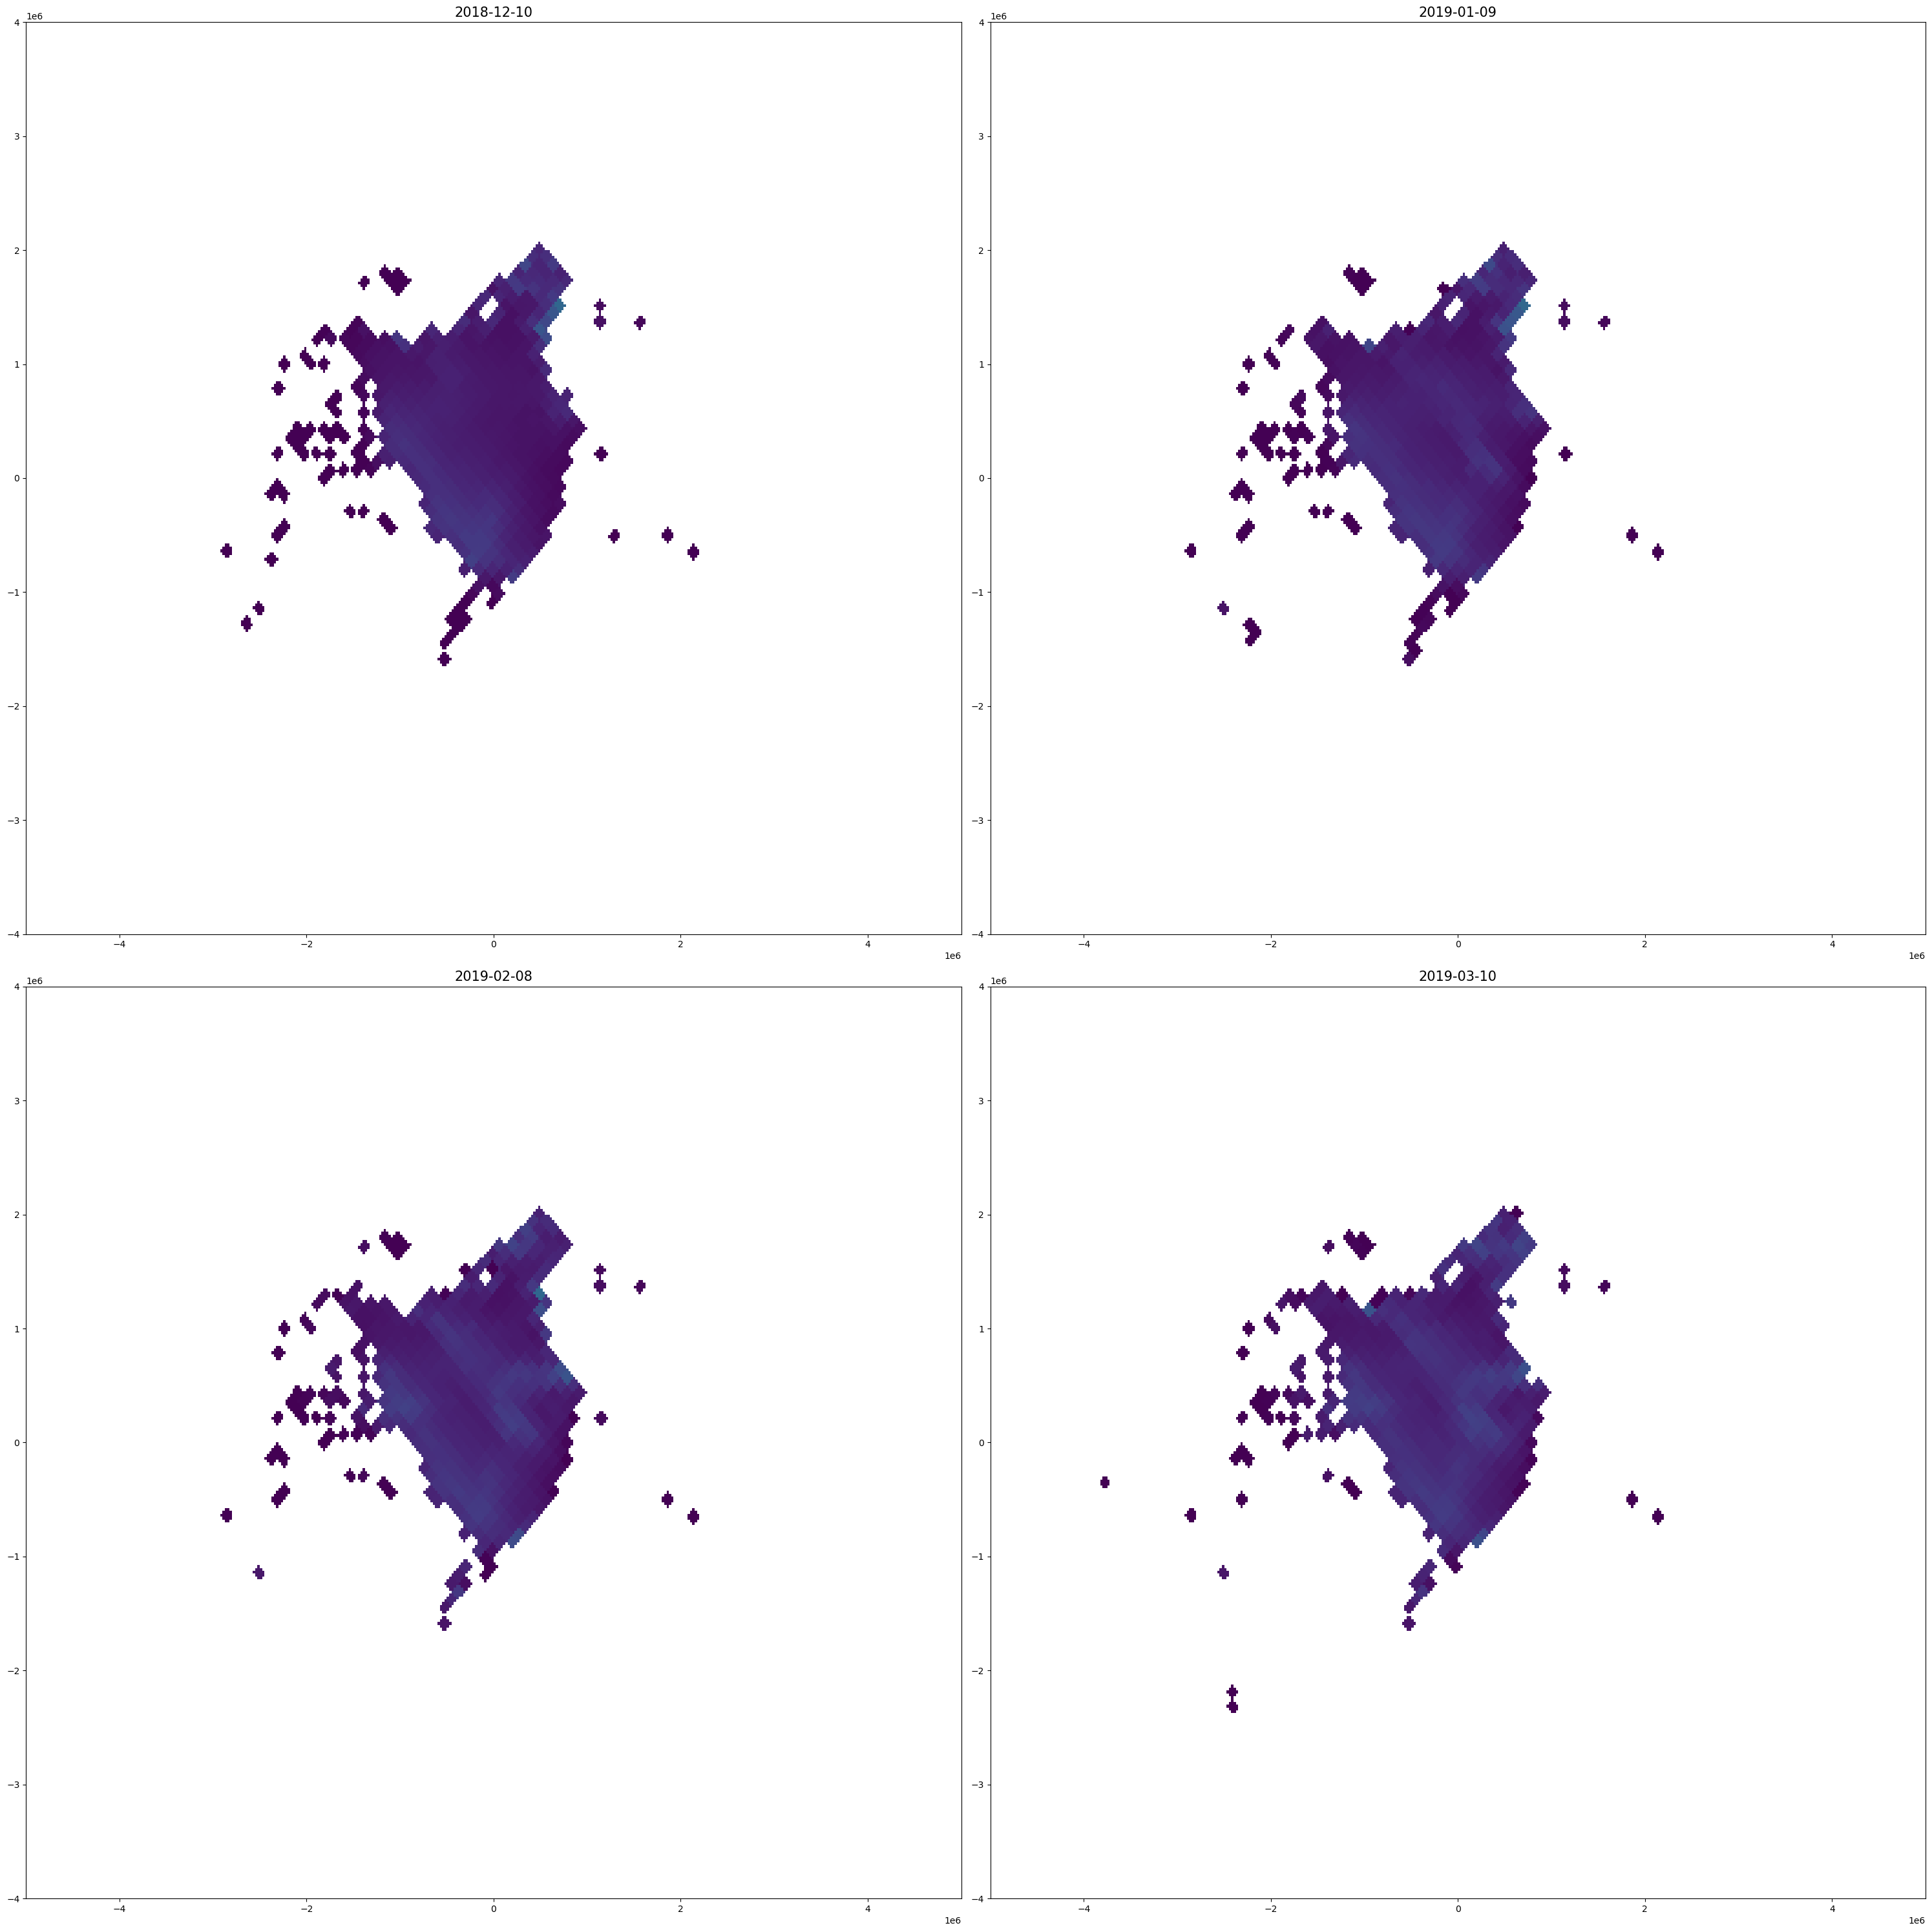

In [50]:
i=0
fig, axes = plt.subplots(2, 2, figsize=[30, 30])
for date in nesosim_ds_regridded.date.values[100:200:30]:
    ax = axes.flatten()[i]
    print(str(date)[0:10])
    nesosim_ds_regridded_day = nesosim_ds_regridded.isel(date=i)
    nesosim_ds_regridded_day.snow_depth.plot(ax=ax, vmin=0, vmax=0.5, add_colorbar=False)
    ax.set_title(str(date)[0:10], fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([-5e6, 5e6])
    ax.set_ylim([-4e6, 4e6])
    i+=1
plt.tight_layout()

In [51]:
nesosim_ds_regridded_monthly = nesosim_ds_regridded.resample(date='MS').mean()
nesosim_ds_regridded_monthly

<xarray.Dataset> Size: 1GB
Dimensions:            (x: 720, y: 720, date: 56)
Coordinates:
  * x                  (x) float64 6kB -8.988e+06 -8.962e+06 ... 8.988e+06
  * y                  (y) float64 6kB 8.988e+06 8.962e+06 ... -8.988e+06
  * date               (date) datetime64[ns] 448B 2018-09-01 ... 2023-04-01
    crs                int32 4B -2147483647
Data variables:
    xgrid              (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    ygrid              (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    snow_depth         (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    snow_volume        (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    snow_density       (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    snowfall           (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    ice_concentration  (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    wind_speed         (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
    precipitation      (date, y, x) float32 116MB dask.array<chunksize=(1, 720, 720), meta=np.ndarray>
Attributes:
    regrid_method:  nearest_s2d

2018-09-01
2018-10-01
2018-11-01
2018-12-01


IndexError: index 4 is out of bounds for axis 0 with size 4

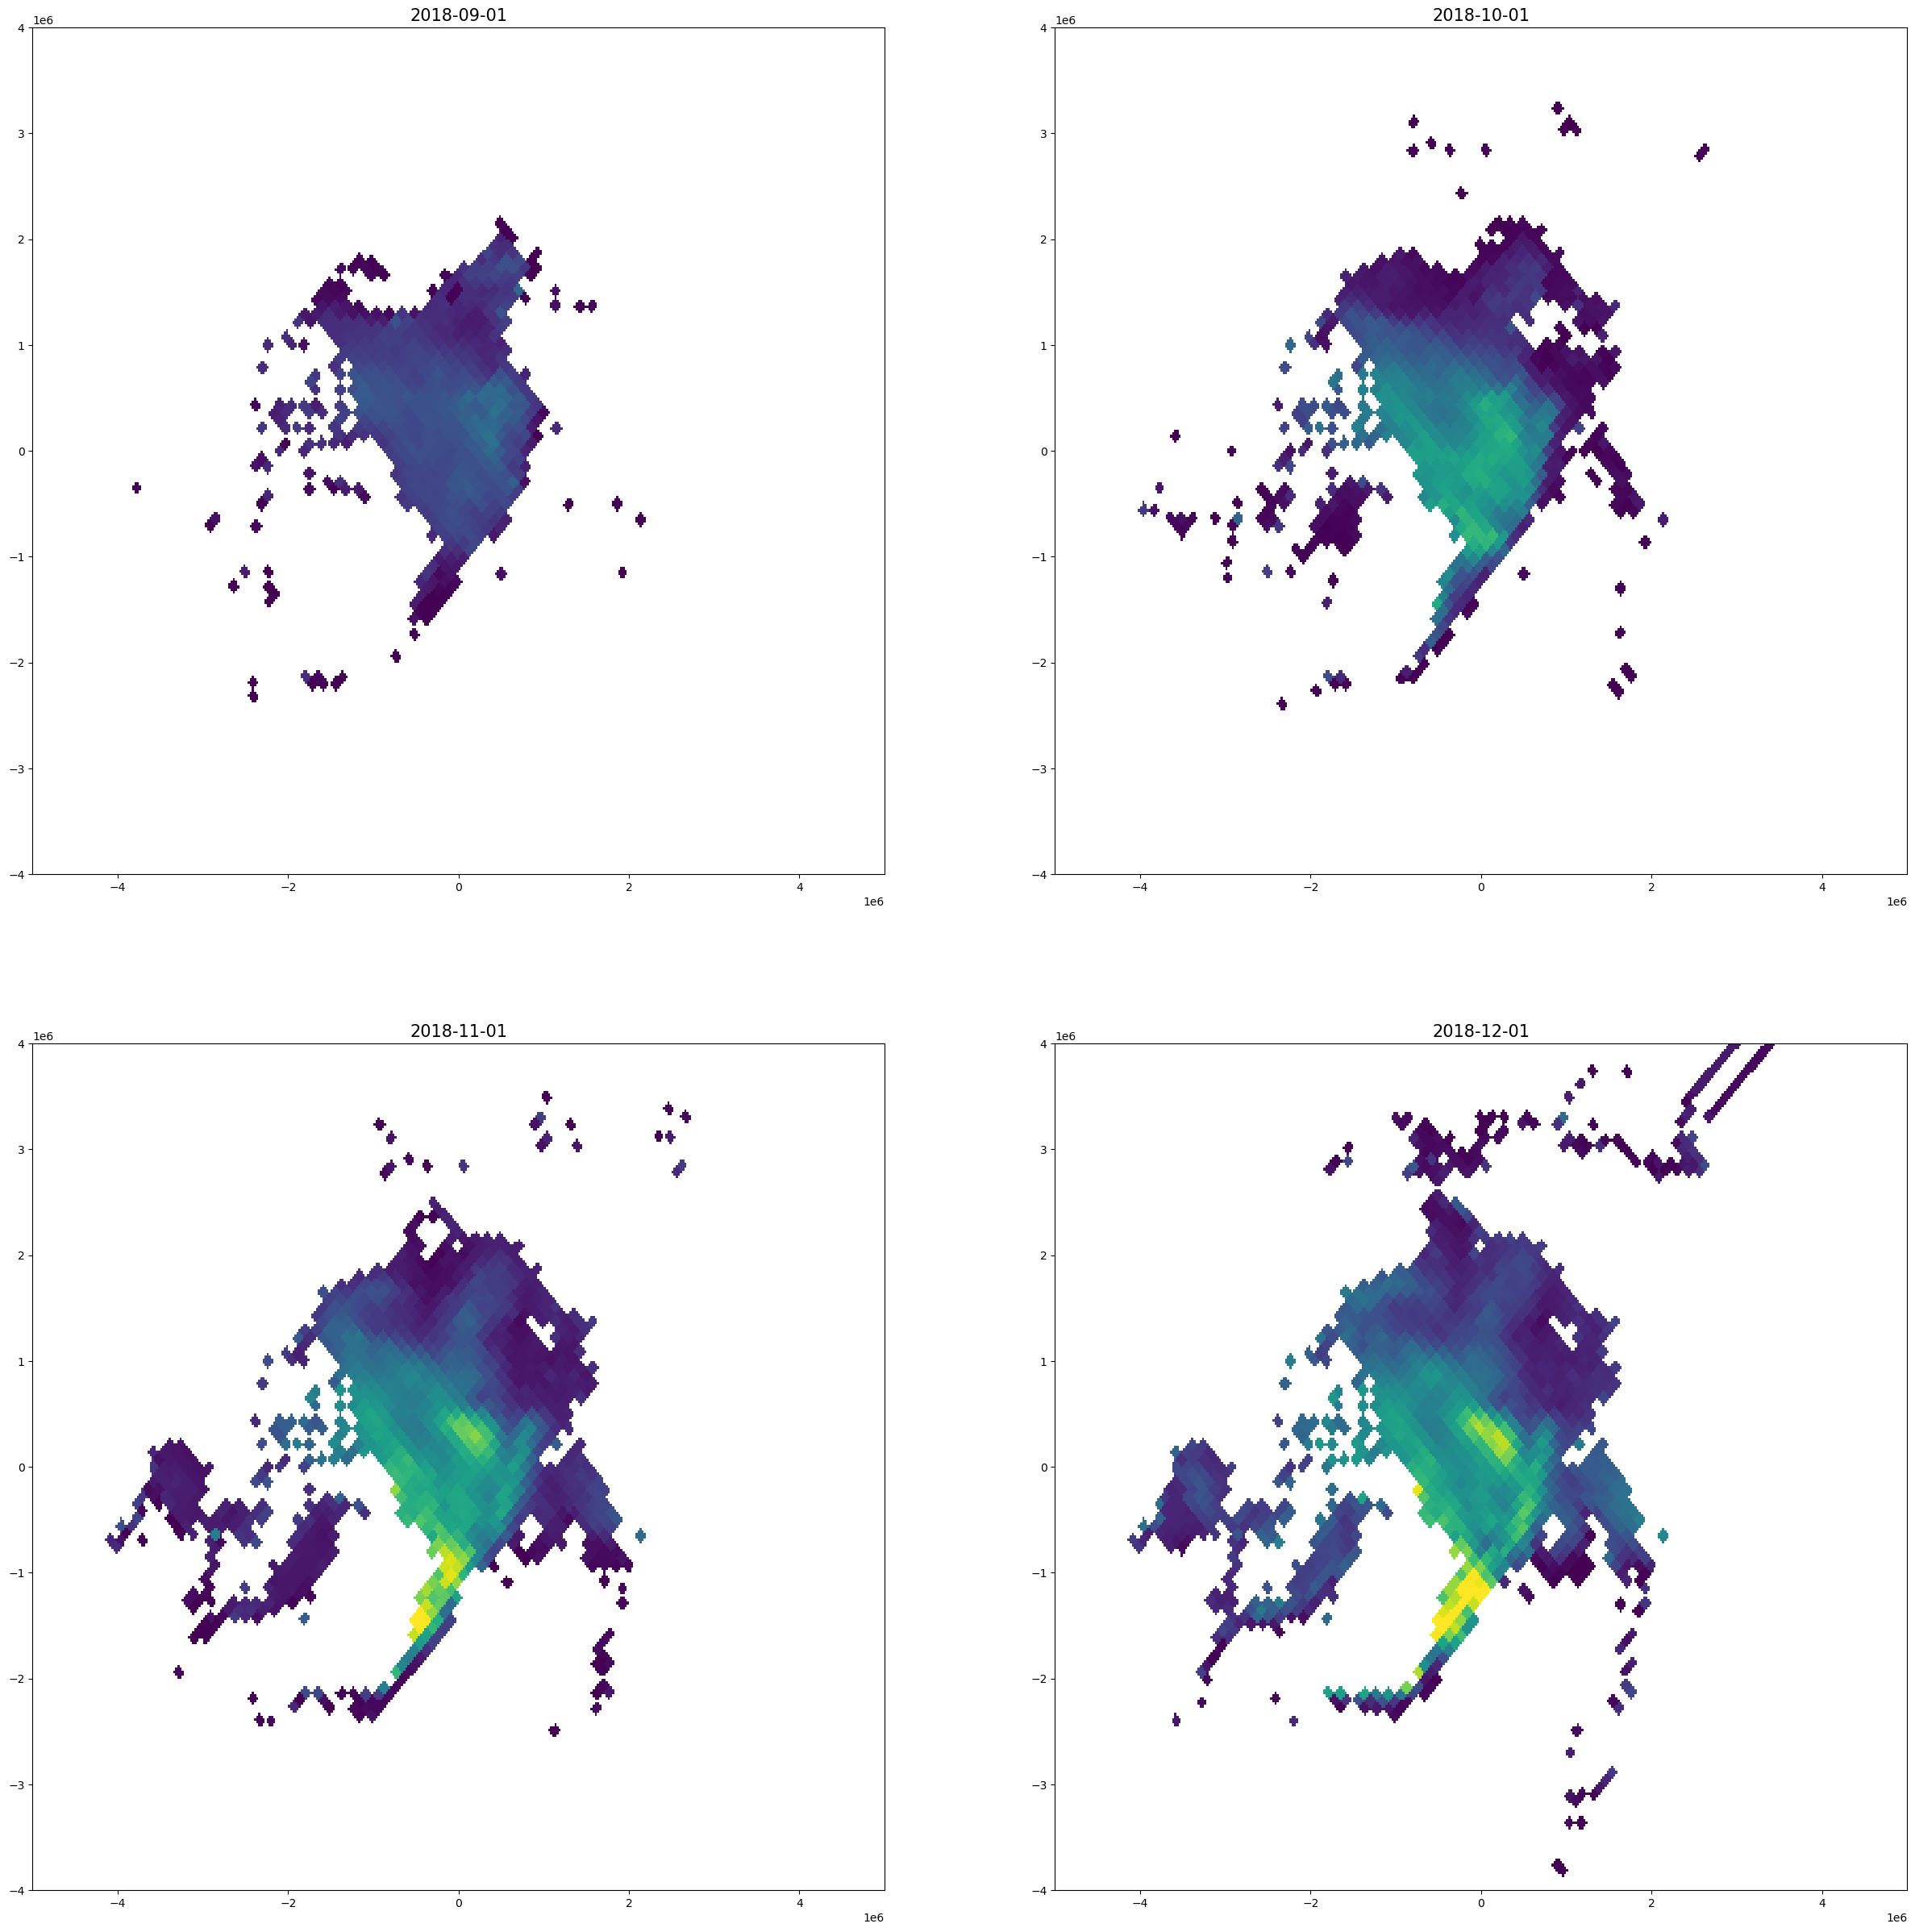

In [52]:
i=0
fig, axes = plt.subplots(2, 2, figsize=[30, 30])
for date in nesosim_ds_regridded_monthly.date.values[0:4]:
    ax = axes.flatten()[i]
    print(str(date)[0:10])
    nesosim_ds_regridded_month = nesosim_ds_regridded_monthly.isel(date=i)
    nesosim_ds_regridded_month.snow_depth.plot(ax=ax, vmin=0, vmax=0.5, add_colorbar=False)
    ax.set_title(str(date)[0:10], fontsize=15)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([-5e6, 5e6])
    ax.set_ylim([-4e6, 4e6])
    i+=1
plt.tight_layout()

In [ ]:
i=0
for date in is2_ds_regridded.time.values:
    print(str(date)[0:7])
    is2_ds_regridded_month = is2_ds_regridded.isel(time=i)
    is2_ds_regridded_month.to_netcdf(path='~/Data/IS2SITMOGR4/v003_EASE/IS2SITMOGR4_01_'+str(date)[0:7]+'006_003_EASE.nc')
    i+=1